In [12]:
# ============================================
# 1. IMPORTS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings

warnings.filterwarnings('ignore')

# Add parent directory to path for preprocessing import
sys.path.append('scripts')
from preprocessing import preprocess

# Model loading
import joblib
import json
from tensorflow import keras

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)


In [13]:
# ============================================
# 2. LOAD PREPROCESSED DATA
# ============================================

X_train, X_val, X_test, y_train, y_val, y_test = preprocess(
    data_path='data/raw/HR_Attrition_Dataset.csv'
)

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True).round(3))
print("=" * 60)


DATASET OVERVIEW
Training set: 882 samples, 19 features
Validation set: 294 samples
Test set: 294 samples

Test set class distribution:
Attrition
0    0.84
1    0.16
Name: proportion, dtype: float64


In [26]:
# ============================================
# 3. LOAD ALL TRAINED MODELS
# ============================================

# Dictionary to store models and their metadata
models = {}

# Load Logistic Regression
try:
    models['Logistic Regression'] = {
        'model': joblib.load('models/logistic_regression_best.pkl'),
        'metadata': json.load(open('models/logreg_model_metadata.json'))
    }
    print("✓ Loaded Logistic Regression")
except Exception as e:
    print(f"✗ Logistic Regression model not found: {e}")

# Load Decision Tree
try:
    models['Decision Tree'] = {
        'model': joblib.load('models/dt_attrition_model.joblib'),
        'metadata': json.load(open('models/dt_model_metadata.json'))
    }
    print("✓ Loaded Decision Tree")
except Exception as e:
    print(f"✗ Decision Tree model not found: {e}")

# Load Random Forest
try:
    models['Random Forest'] = {
        'model': joblib.load('models/rf_attrition_model.joblib'),
        'metadata': json.load(open('models/rf_model_metadata.json'))
    }
    print("✓ Loaded Random Forest")
except Exception as e:
    print(f"✗ Random Forest model not found: {e}")

# Load XGBoost
try:
    models['XGBoost'] = {
        'model': joblib.load('models/xgboost_attrition_model.joblib'),
        'metadata': json.load(open('models/xgboost_model_metadata.json'))
    }
    print("✓ Loaded XGBoost")
except Exception as e:
    print(f"✗ XGBoost model not found: {e}")

# Load Neural Network
try:
    models['Neural Network'] = {
        'model': keras.models.load_model('models/nn_attrition_model.h5', compile=False),
        'metadata': json.load(open('models/nn_model_metadata.json'))
    }
    print("✓ Loaded Neural Network")
except Exception as e:
    print(f"✗ Neural Network model not found: {e}")

print(f"\n{'='*60}")
print(f"✓ Successfully loaded {len(models)} models")
print(f"{'='*60}")


✓ Loaded Logistic Regression
✓ Loaded Decision Tree
✓ Loaded Random Forest
✓ Loaded XGBoost
✓ Loaded Neural Network

✓ Successfully loaded 5 models


In [27]:
# ============================================
# 4. GENERATE PREDICTIONS FOR ALL MODELS
# ============================================

predictions = {}

for model_name, model_dict in models.items():
    model = model_dict['model']
    metadata = model_dict['metadata']
    
    # Get probabilities
    if model_name == 'Neural Network':
        y_proba = model.predict(X_test.values.astype(np.float32), verbose=0).ravel()
    else:
        y_proba = model.predict_proba(X_test)[:, 1]
    
    # Get thresholds from metadata
    thresholds = metadata.get('thresholds', {})
    default_threshold = thresholds.get('default', 0.5)
    f1_threshold = thresholds.get('f1_optimized', 0.5)
    recall_threshold = thresholds.get('recall_optimized', 0.5)
    
    # Make predictions with different thresholds
    predictions[model_name] = {
        'probabilities': y_proba,
        'pred_default': (y_proba >= default_threshold).astype(int),
        'pred_f1': (y_proba >= f1_threshold).astype(int),
        'pred_recall': (y_proba >= recall_threshold).astype(int),
        'thresholds': thresholds,
        'auc': roc_auc_score(y_test, y_proba)
    }

print("✓ Generated predictions for all models")


✓ Generated predictions for all models


In [28]:
# ============================================
# 5. CALCULATE METRICS FOR ALL MODELS
# ============================================

results = []

for model_name, pred_dict in predictions.items():
    y_proba = pred_dict['probabilities']
    
    # For each threshold strategy
    for strategy, y_pred in [
        ('Default (0.50)', pred_dict['pred_default']),
        ('F1-Optimized', pred_dict['pred_f1']),
        ('Recall-Optimized', pred_dict['pred_recall'])
    ]:
        cm = confusion_matrix(y_test, y_pred)
        
        results.append({
            'Model': model_name,
            'Threshold Strategy': strategy,
            'AUC': pred_dict['auc'],
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1 Score': f1_score(y_test, y_pred, zero_division=0),
            'True Negatives': cm[0, 0],
            'False Positives': cm[0, 1],
            'False Negatives': cm[1, 0],
            'True Positives': cm[1, 1],
            'Missed Departures': cm[1, 0],
            'False Alarms': cm[0, 1]
        })

results_df = pd.DataFrame(results)
print("✓ Calculated metrics for all models and threshold strategies")


✓ Calculated metrics for all models and threshold strategies


In [29]:
# ============================================
# 6. MODEL COMPARISON TABLE - RECALL-OPTIMIZED ONLY
# ============================================

# Filter for recall-optimized threshold only
recall_opt_df = results_df[results_df['Threshold Strategy'] == 'Recall-Optimized'].copy()
recall_opt_df = recall_opt_df.sort_values('Recall', ascending=False)

# Display comparison table
print("\n" + "=" * 100)
print("MODEL COMPARISON - RECALL-OPTIMIZED THRESHOLD (BUSINESS PRIORITY)")
print("=" * 100)
comparison_cols = ['Model', 'AUC', 'Recall', 'Precision', 'F1 Score', 
                   'Missed Departures', 'False Alarms', 'Accuracy']
print(recall_opt_df[comparison_cols].to_string(index=False))
print("=" * 100)

# Identify best model
best_model = recall_opt_df.iloc[0]['Model']
best_recall = recall_opt_df.iloc[0]['Recall']
best_missed = recall_opt_df.iloc[0]['Missed Departures']

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   ├─ Recall: {best_recall:.1%}")
print(f"   ├─ Missed Departures: {int(best_missed)} out of {int(y_test.sum())}")
print(f"   └─ AUC: {recall_opt_df.iloc[0]['AUC']:.3f}")



MODEL COMPARISON - RECALL-OPTIMIZED THRESHOLD (BUSINESS PRIORITY)
              Model      AUC   Recall  Precision  F1 Score  Missed Departures  False Alarms  Accuracy
Logistic Regression 0.804807 0.808511   0.322034  0.460606                  9            80  0.697279
      Decision Tree 0.701352 0.744681   0.231788  0.353535                 12           116  0.564626
      Random Forest 0.767766 0.744681   0.301724  0.429448                 12            81  0.683673
            XGBoost 0.749419 0.702128   0.282051  0.402439                 14            84  0.666667
     Neural Network 0.752520 0.702128   0.317308  0.437086                 14            71  0.710884

🏆 BEST MODEL: Logistic Regression
   ├─ Recall: 80.9%
   ├─ Missed Departures: 9 out of 47
   └─ AUC: 0.805


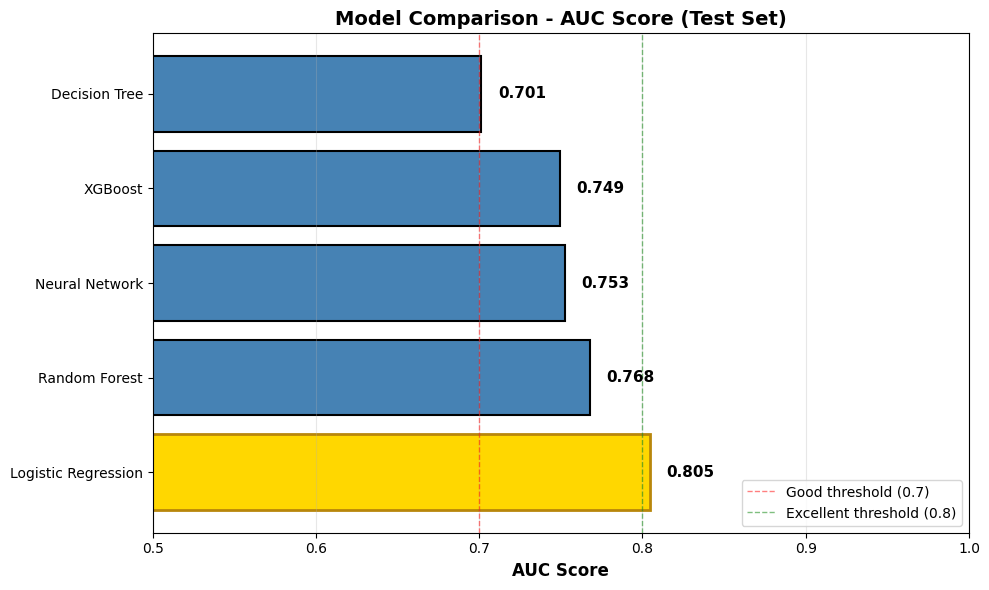

In [30]:
# ============================================
# 7. VISUALIZE AUC COMPARISON
# ============================================

# Get unique models and their AUC scores
auc_data = results_df.groupby('Model')['AUC'].first().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(auc_data.index, auc_data.values, color='steelblue', edgecolor='black', linewidth=1.5)

# Highlight best model
bars[0].set_color('gold')
bars[0].set_edgecolor('darkgoldenrod')
bars[0].set_linewidth(2)

# Add value labels
for i, (model, auc) in enumerate(auc_data.items()):
    ax.text(auc + 0.01, i, f'{auc:.3f}', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - AUC Score (Test Set)', fontsize=14, fontweight='bold')
ax.set_xlim([0.5, 1.0])
ax.axvline(x=0.7, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Good threshold (0.7)')
ax.axvline(x=0.8, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Excellent threshold (0.8)')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


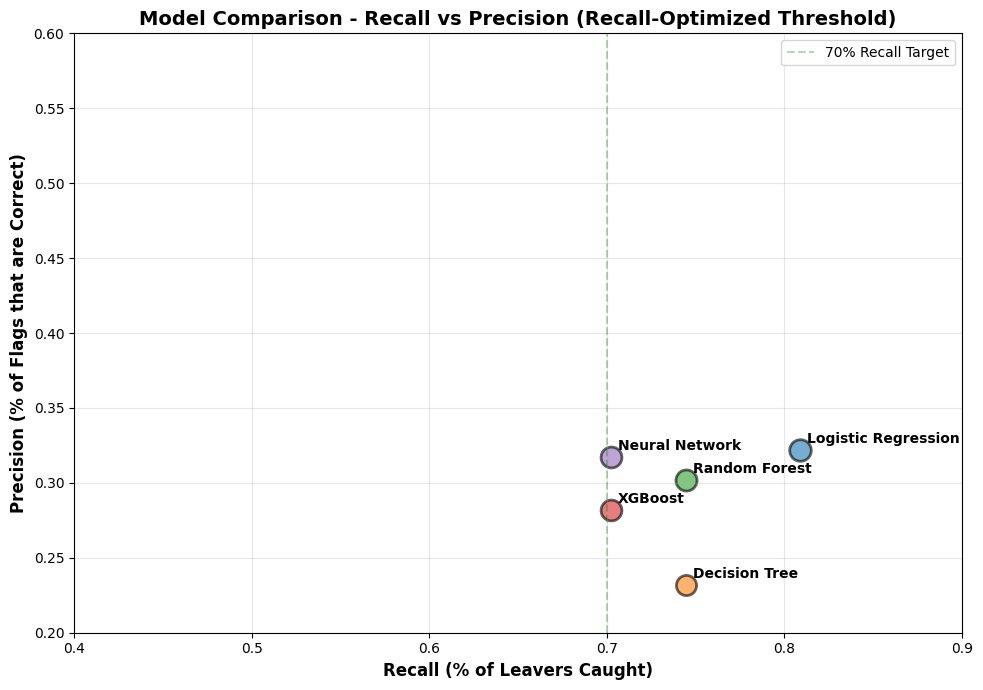

In [31]:
# ============================================
# 8. VISUALIZE RECALL VS PRECISION TRADEOFF
# ============================================

fig, ax = plt.subplots(figsize=(10, 7))

# Plot recall-optimized performance for each model
for model_name in recall_opt_df['Model']:
    model_data = recall_opt_df[recall_opt_df['Model'] == model_name].iloc[0]
    recall = model_data['Recall']
    precision = model_data['Precision']
    
    # Marker size based on AUC
    size = model_data['AUC'] * 300
    
    ax.scatter(recall, precision, s=size, alpha=0.6, edgecolors='black', linewidth=2)
    ax.annotate(model_name, (recall, precision), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

ax.set_xlabel('Recall (% of Leavers Caught)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision (% of Flags that are Correct)', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - Recall vs Precision (Recall-Optimized Threshold)', 
             fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim([0.4, 0.9])
ax.set_ylim([0.2, 0.6])

# Add reference lines
ax.axvline(x=0.7, color='green', linestyle='--', alpha=0.3, label='70% Recall Target')
ax.legend()

plt.tight_layout()
plt.show()


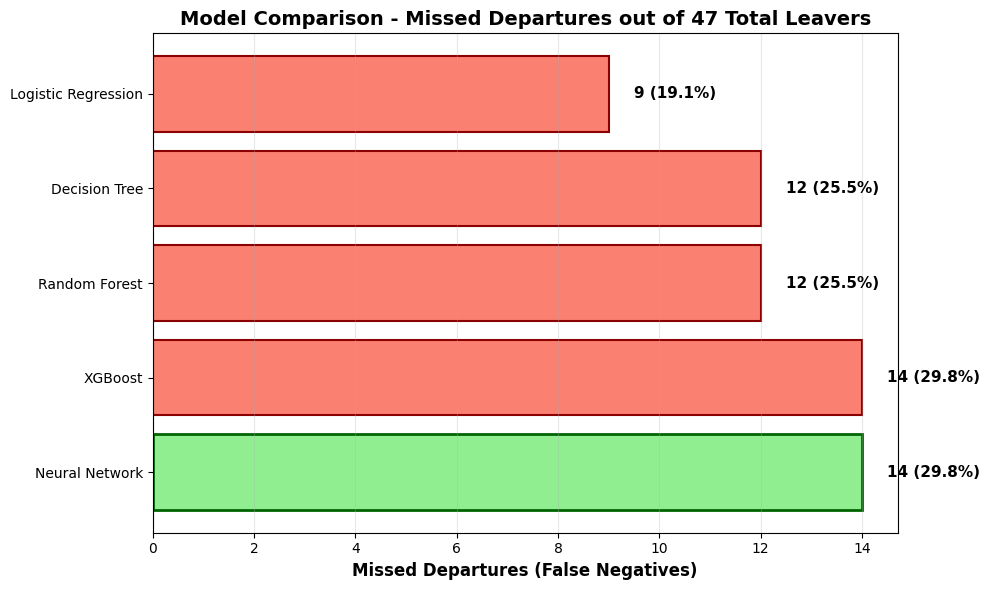

In [32]:
# ============================================
# 9. VISUALIZE MISSED DEPARTURES COMPARISON
# ============================================

# Prepare data
missed_data = recall_opt_df.sort_values('Missed Departures')

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(missed_data['Model'], missed_data['Missed Departures'], 
               color='salmon', edgecolor='darkred', linewidth=1.5)

# Highlight best model (lowest missed departures)
bars[-1].set_color('lightgreen')
bars[-1].set_edgecolor('darkgreen')
bars[-1].set_linewidth(2)

# Add value labels
for i, (idx, row) in enumerate(missed_data.iterrows()):
    missed = row['Missed Departures']
    total = int(y_test.sum())
    percentage = (missed / total) * 100
    ax.text(missed + 0.5, i, f'{int(missed)} ({percentage:.1f}%)', 
            va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Missed Departures (False Negatives)', fontsize=12, fontweight='bold')
ax.set_title(f'Model Comparison - Missed Departures out of {int(y_test.sum())} Total Leavers', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


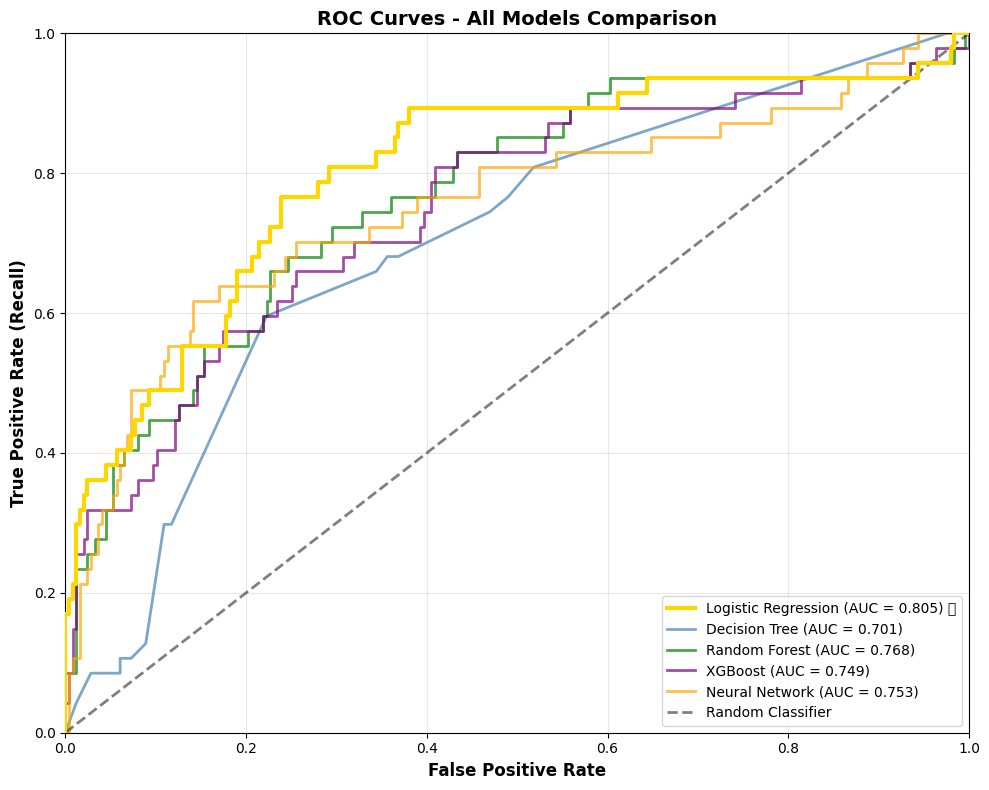

In [33]:
# ============================================
# 10. ROC CURVES - ALL MODELS COMPARISON
# ============================================

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['gold', 'steelblue', 'green', 'purple', 'orange']

for i, (model_name, pred_dict) in enumerate(predictions.items()):
    y_proba = pred_dict['probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = pred_dict['auc']
    
    # Use thicker line and different color for best model
    if model_name == best_model:
        ax.plot(fpr, tpr, linewidth=3, label=f'{model_name} (AUC = {auc:.3f}) ⭐', 
                color=colors[i], zorder=10)
    else:
        ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc:.3f})', 
                color=colors[i], alpha=0.7)

# Random classifier
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier', alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()


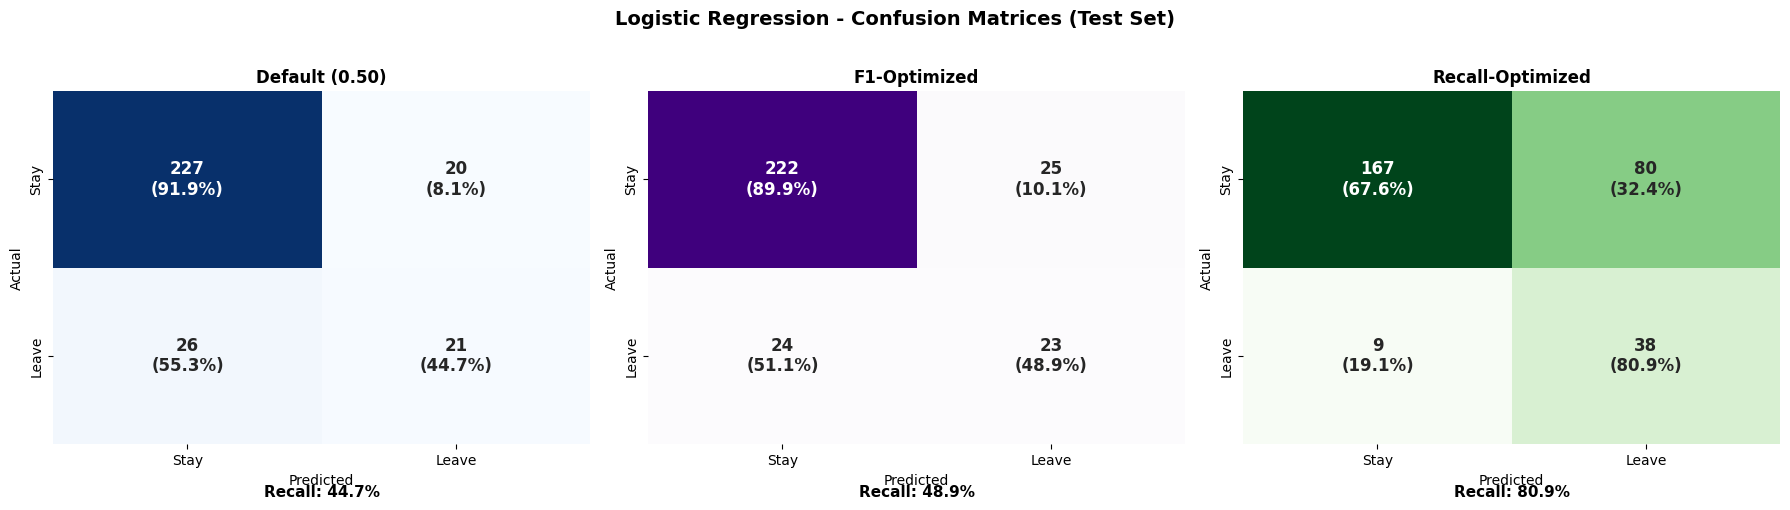

In [34]:
# ============================================
# 11. CONFUSION MATRICES - BEST MODEL (ALL THRESHOLDS)
# ============================================

best_model_preds = predictions[best_model]

fig = plt.figure(figsize=(18, 5))
gs = fig.add_gridspec(1, 3)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

thresholds_data = [
    ("Default (0.50)", best_model_preds['pred_default']),
    ("F1-Optimized", best_model_preds['pred_f1']),
    ("Recall-Optimized", best_model_preds['pred_recall'])
]

cmaps = ['Blues', 'Purples', 'Greens']

for idx, ((title, y_pred), cmap) in enumerate(zip(thresholds_data, cmaps)):
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with counts and percentages
    annot = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)' 
                       for j in range(cm.shape[1])] 
                      for i in range(cm.shape[0])])
    
    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap,
                xticklabels=['Stay', 'Leave'],
                yticklabels=['Stay', 'Leave'],
                cbar=False, ax=axes[idx],
                annot_kws={'size': 12, 'weight': 'bold'})
    
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    
    # Add recall at bottom
    recall = recall_score(y_test, y_pred)
    axes[idx].text(0.5, -0.15, f'Recall: {recall:.1%}', 
                   transform=axes[idx].transAxes,
                   fontsize=11, fontweight='bold',
                   horizontalalignment='center')

plt.suptitle(f'{best_model} - Confusion Matrices (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [35]:
# ============================================
# 12. BUSINESS IMPACT SUMMARY - RECALL-OPTIMIZED
# ============================================

print("\n" + "=" * 100)
print("BUSINESS IMPACT SUMMARY - RECALL-OPTIMIZED THRESHOLD")
print("=" * 100)

total_leavers = int(y_test.sum())
total_employees = len(y_test)

for idx, row in recall_opt_df.iterrows():
    model_name = row['Model']
    caught = int(row['True Positives'])
    missed = int(row['Missed Departures'])
    false_alarms = int(row['False Alarms'])
    recall = row['Recall']
    precision = row['Precision']
    
    print(f"\n{model_name}:")
    print(f"  ├─ Leavers Caught: {caught}/{total_leavers} ({recall:.1%})")
    print(f"  ├─ Missed Departures: {missed}/{total_leavers}")
    print(f"  ├─ False Alarms: {false_alarms}/{total_employees - total_leavers}")
    print(f"  ├─ Precision: {precision:.1%}")
    print(f"  └─ Total Flagged: {caught + false_alarms} employees")

print("\n" + "=" * 100)



BUSINESS IMPACT SUMMARY - RECALL-OPTIMIZED THRESHOLD

Logistic Regression:
  ├─ Leavers Caught: 38/47 (80.9%)
  ├─ Missed Departures: 9/47
  ├─ False Alarms: 80/247
  ├─ Precision: 32.2%
  └─ Total Flagged: 118 employees

Decision Tree:
  ├─ Leavers Caught: 35/47 (74.5%)
  ├─ Missed Departures: 12/47
  ├─ False Alarms: 116/247
  ├─ Precision: 23.2%
  └─ Total Flagged: 151 employees

Random Forest:
  ├─ Leavers Caught: 35/47 (74.5%)
  ├─ Missed Departures: 12/47
  ├─ False Alarms: 81/247
  ├─ Precision: 30.2%
  └─ Total Flagged: 116 employees

XGBoost:
  ├─ Leavers Caught: 33/47 (70.2%)
  ├─ Missed Departures: 14/47
  ├─ False Alarms: 84/247
  ├─ Precision: 28.2%
  └─ Total Flagged: 117 employees

Neural Network:
  ├─ Leavers Caught: 33/47 (70.2%)
  ├─ Missed Departures: 14/47
  ├─ False Alarms: 71/247
  ├─ Precision: 31.7%
  └─ Total Flagged: 104 employees



In [ ]:
# ============================================
# 13. EXPORT COMPARISON RESULTS
# ============================================

# Create models directory if it doesn't exist
MODELS_PATH = 'models/'
os.makedirs(MODELS_PATH, exist_ok=True)

# Save full results
results_path = os.path.join(MODELS_PATH, 'model_comparison_full.csv')
results_df.to_csv(results_path, index=False)

# Save recall-optimized summary
recall_opt_path = os.path.join(MODELS_PATH, 'model_comparison_recall_optimized.csv')
recall_opt_df.to_csv(recall_opt_path, index=False)

# Create summary report
summary = {
    'best_model': best_model,
    'best_model_metrics': recall_opt_df.iloc[0].to_dict(),
    'total_leavers': int(y_test.sum()),
    'total_employees': len(y_test),
    'all_models_summary': recall_opt_df[['Model', 'AUC', 'Recall', 'Precision', 
                                          'Missed Departures', 'False Alarms']].to_dict('records')
}

summary_path = os.path.join(MODELS_PATH, 'model_comparison_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)

print("\n✓ Comparison results exported:")
print(f"  ├─ {results_path}")
print(f"  ├─ {recall_opt_path}")
print(f"  └─ {summary_path}")


In [36]:
# ============================================
# 14. FINAL RECOMMENDATION
# ============================================

print("\n" + "=" * 100)
print("🏆 FINAL RECOMMENDATION")
print("=" * 100)
print(f"\nDeploy: {best_model} with Recall-Optimized Threshold")
print(f"\nKey Metrics:")
print(f"  ├─ AUC: {recall_opt_df.iloc[0]['AUC']:.3f}")
print(f"  ├─ Recall: {recall_opt_df.iloc[0]['Recall']:.1%}")
print(f"  ├─ Precision: {recall_opt_df.iloc[0]['Precision']:.1%}")
print(f"  ├─ Missed Departures: {int(recall_opt_df.iloc[0]['Missed Departures'])}/{total_leavers}")
print(f"  └─ False Alarms: {int(recall_opt_df.iloc[0]['False Alarms'])}/{total_employees - total_leavers}")

print(f"\nBusiness Impact:")
print(f"  ├─ Catches {recall_opt_df.iloc[0]['Recall']:.1%} of employees planning to leave")
print(f"  ├─ Requires intervention with {int(recall_opt_df.iloc[0]['True Positives'] + recall_opt_df.iloc[0]['False Alarms'])} employees")
print(f"  └─ Minimizes surprise departures for proactive retention")

print("\n" + "=" * 100)



🏆 FINAL RECOMMENDATION

Deploy: Logistic Regression with Recall-Optimized Threshold

Key Metrics:
  ├─ AUC: 0.805
  ├─ Recall: 80.9%
  ├─ Precision: 32.2%
  ├─ Missed Departures: 9/47
  └─ False Alarms: 80/247

Business Impact:
  ├─ Catches 80.9% of employees planning to leave
  ├─ Requires intervention with 118 employees
  └─ Minimizes surprise departures for proactive retention

